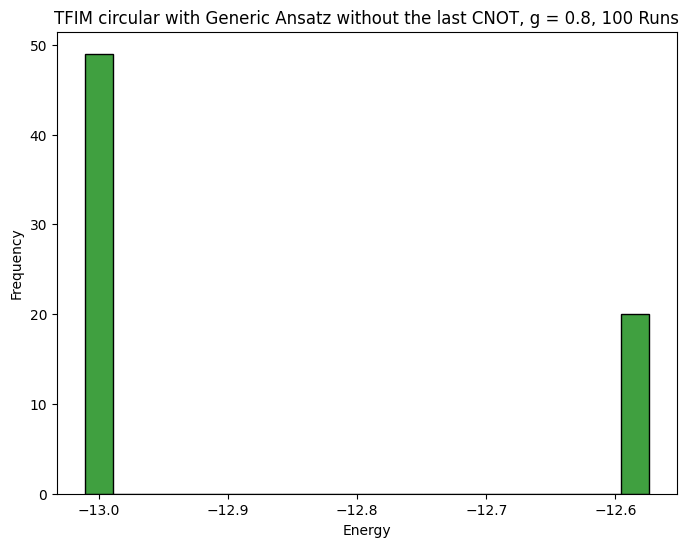

Lowest energy achieved: -13.010941


In [20]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit.primitives import Estimator
from qiskit.circuit import ParameterVector
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor, as_completed
import time


# Generate the Hamiltonian for a specified g and number of qubits
def hamiltonian_sparse_pauli(g, num_qubits):
    pauli_terms = []
    coefficients = []

    # Add ZZ interaction terms for nearest neighbors
    #for i in range(num_qubits - 1):
        #label = ["I"] * num_qubits
        #label[i] = "Z"
        #label[i + 1] = "Z"
        #pauli_terms.append(Pauli("".join(label)))
        #coefficients.append(-1)
    
    # Add ZZ interaction terms for nearest neighbors with periodic boundary conditions
    for i in range(num_qubits):  # Include the last pair (last qubit and first qubit)
        label = ["I"] * num_qubits
        label[i] = "Z"
        label[(i + 1) % num_qubits] = "Z"  # Use modulo to wrap around for periodic boundary
        pauli_terms.append(Pauli("".join(label)))
        coefficients.append(-1)    

    # Add transverse field X terms with coefficient -g
    for i in range(num_qubits):
        label = ["I"] * num_qubits
        label[i] = "X"
        pauli_terms.append(Pauli("".join(label)))
        coefficients.append(-g)

    # Create the Hamiltonian as a SparsePauliOp
    H = SparsePauliOp(pauli_terms, coefficients)
    return H

# Define the ansatz circuit
def ansatz(num_qubits):
    qc = QuantumCircuit(num_qubits)
    theta = ParameterVector('θ', num_qubits)

    # Parameterized Y rotations
    for i in range(num_qubits):
        qc.ry(theta[i], i)

    # CNOT chain entanglement
    for i in range(num_qubits - 1):
        qc.cx(i, i + 1)
    #qc.cx(num_qubits - 1, 0)  # Wrap-around entanglement

    return qc, theta

# Define the cost function for optimization
def cost_function(params, hamiltonian, num_qubits):
    qc, theta = ansatz(num_qubits)
    param_dict = {theta[i]: params[i] for i in range(num_qubits)}
    bound_circuit = qc.assign_parameters(param_dict)

    estimator = Estimator()
    result = estimator.run(bound_circuit, [hamiltonian])
    expectation_value = result.result().values[0]

    return expectation_value

# Optimization loop with timeout
def optimization_loop_with_timeout(hamiltonian, num_qubits, optimizer, initial_params, timeout=30):
    start_time = time.time()

    def cost(params):
        return cost_function(params, hamiltonian, num_qubits)

    result = None
    try:
        result = minimize(
            cost,
            initial_params,
            method=optimizer,
            options={'maxiter': 1000, 'tol': 1e-3},
            callback=lambda xk: (time.time() - start_time) < timeout,
        )
    except Exception as e:
        print(f"Optimization failed: {e}")

    if result and result.success:
        return result.fun, result.x
    else:
        return None, None

# Parallel optimization runs
def run_multiple_optimizations_parallel(num_runs, hamiltonian, num_qubits, optimizer, timeout=60):
    energies = []
    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(
                optimization_loop_with_timeout,
                hamiltonian,
                num_qubits,
                optimizer,
                np.random.uniform(0, 2 * np.pi, num_qubits),
                timeout,
            )
            for _ in range(num_runs)
        ]
        for future in as_completed(futures):
            optimal_value, _ = future.result()
            if optimal_value is not None:
                energies.append(optimal_value)
    return energies

# Set parameters for the Hamiltonian and ansatz
g = 0.8
num_qubits = 12
qubit_hamiltonian = hamiltonian_sparse_pauli(g, num_qubits)
optimizer = 'COBYLA'
num_runs = 100
timeout = 60

# Perform parallel optimization
energies = run_multiple_optimizations_parallel(num_runs, qubit_hamiltonian, num_qubits, optimizer, timeout)

# Plot results
plt.figure(figsize=(8, 6))
sns.histplot(energies, kde=False, bins=20, color='green')
plt.title('TFIM circular with Generic Ansatz without the last CNOT, g = 0.8, 100 Runs')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.show()

# Print the best energy achieved
if energies:
    print(f'Lowest energy achieved: {min(energies):.6f}')
else:
    print("No successful optimizations.")


Exact ground state energy: -14.021144 Hartree


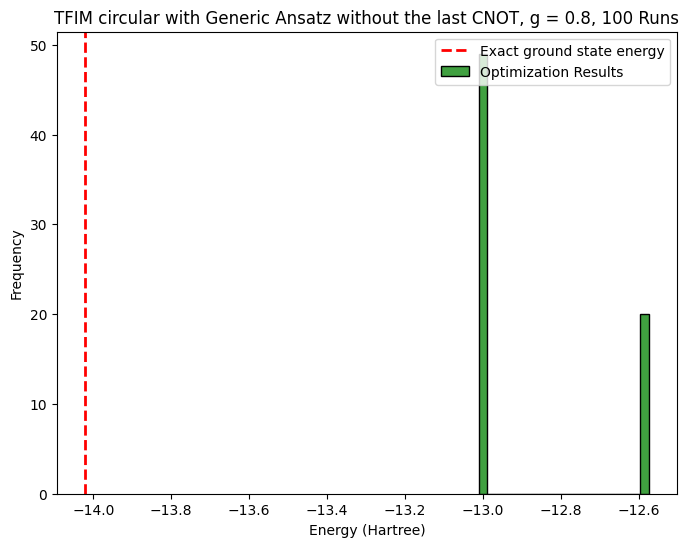

In [21]:
from qiskit_algorithms import NumPyMinimumEigensolver

# Calculate the exact ground state energy
exact_solver = NumPyMinimumEigensolver()
exact_result = exact_solver.compute_minimum_eigenvalue(qubit_hamiltonian)
exact_energy = exact_result.eigenvalue.real
print(f'Exact ground state energy: {exact_energy:.6f} Hartree')

# Re-plot the histogram and overlay the exact energy line
plt.figure(figsize=(8, 6))
sns.histplot(energies, kde=False, bins=20, color='green', label='Optimization Results')

# Add the exact energy line
plt.axvline(exact_energy, color='red', linestyle='--', linewidth=2, label='Exact ground state energy')

# Plot settings
plt.title('TFIM circular with Generic Ansatz without the last CNOT, g = 0.8, 100 Runs')
plt.xlabel('Energy (Hartree)')
plt.ylabel('Frequency')
plt.legend()
plt.draw()